# Music Machine Learning - feature-based mining (nearest neighbors)

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. A [quick recap](#recap) on the idea of feature-based learning
2. An introduction to [Nearest Neighbors](#nn) for querying
3. An implementation of [classification](#classification) using k-NN
4. A discussion on the [evaluation](#evaluation) of classification results

<a id="recap"> </a>

## Feature-based learning

This tutorials corresponds to the same slides following the introductory developments performed in the [previous tutorial](01a_machine_learning.ipynb). As we have seen previously, we can compute a whole set of features out of audio waveforms. These features were used in the traditional approaches of machine learning, which performed _feature-based learning_. If we look at the space induced by these features, we can clearly see that similar examples are somewhat grouped together.

<img src="images/01_knn_space.png" align="center"/>

Therefore, a naive way to approach the problem would be to look at examples in our training set that are near a new (unseen) file. Based on the features computed, we will implement a simple *querying* and *classification* system based on [Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

<a id="nn"> </a>
## Nearest-neighbors

In this tutorial, we will cover the simplest querying and classification algorithm, namely the *$k$-Nearest Neighbor* method. The idea is for a given (usually *unknown*) element, to find its closest neighbor(s), based on the distances between this element and the known dataset for a given set of features. Formally, given a set of elements $e_{i}$, $i\in\left[1,N\right]$ and their corresponding features $\mathbf{f_{i,m}}\in\mathbb{R}^{d}$ (which denotes the $m^{th}$ feature of the $i^{th}$ element, which can be $d$-dimensional), we will need to compute a distance measure $\mathcal{D}\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)$ between the features of elements of the dataset. This distance will express the dissimilarity between two features. For the first two questions of the tutorial, we will simply consider that the dissimilarity between features is expressed by their Euclidean $(l_{2})$ distance.

$$
\begin{equation}
\mathcal{D}\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)=\sqrt{\sum_{d=1}^{D}\left(f_{i,m}^{d}-f_{j,m}^{d}\right)^{2}}
\end{equation}
$$

Given distances for each feature, we need to *merge* these various dissimilarities and then select the nearest neighbor of a particular element by computing

$$
\begin{equation}
kNN\left(e_{i}\right)=\overset{k}{\underset{j\neq i}{argmin}}\left(\frac{1}{M}\sum_{m=1}^{M}\left(\mathcal{D}\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)\right)\right)
\end{equation}
$$


***

**Questions**  

  1. What problems can arise from $n$-dimensional audio features?
  2. Based on the selection equation, what constraints are implicitly made on the distances?
  3. Does the Euclidean distance seems like a sound way to measure the similarity between temporal features?
  
***

In [3]:
from helper_data import import_dataset, compute_transforms, compute_features
class_path = 'data/classification'
# 0.1 - Import the classification dataset
data_struct = import_dataset(class_path, 'classification')
# 0.2 - Pre-process the audio to obtain spectral transforms 
data_struct = compute_transforms(data_struct)
# 0.3 - Compute a set of temporal and spectral features
data_struct = compute_features(data_struct)

    - Importing dataset data/classification.

    - Performing transforms.
    - Performing features.


## Querying 

First, we can use the nearest-neighbor idea to devise a very simple *querying* system. This type of method is typically used in many systems such as *Query By Humming (QBH)* softwares (similar to [Shazam](http://www.shazam.com/)). As previously, we provide a baseline code in the main script. First, we create a $ N \times M $ distance matrix `data_matrix` corresponding to the $M$ features of the $ N $ elements of the datasets. We selected here only the *spectral_centroid_mean, SpectralFlatnessMean* and *SpectralSkewnessMean* features. 

In [6]:
used_features = ['spectral_centroid_mean', 'loudness_mean', 'spectral_contrast_mean']
# Create a data matrix only from selected features
data_matrix = np.zeros((len(data_struct["filenames"]), len(used_features)))
for f in range(len(used_features)):
    data_matrix[:, f] = data_struct[used_features[f]]
# Avoid NaN and inf values
data_matrix = np.nan_to_num(data_matrix)
# Normalize the matrix (unit-variance)
for f in range(len(used_features)):
    data_matrix[:,f] = (data_matrix[:, f] - np.mean(data_matrix[:, f])) / np.std(data_matrix[:, f])

# My code here
dist = np.zeros((len(data_matrix), len(data_matrix)))
dist2 = np.zeros((len(data_matrix), len(data_matrix)))
for i in range(len(data_matrix)):
    for j in range(len(data_matrix)):
        dist[i, j] = lp_distance(data_matrix[i, :], data_matrix[j, :], p=2)
        #dist[i, j] = correlation_distance(data_matrix[i, :], data_matrix[j, :])

Then, after your code is filled, the `dist` matrix should contain the mean distances (eventually, for various types of distances), which will then be sorted to the `nn_ids` vector allowing to select the nearest neighbors.

***

**Exercise**  

  1. Compute the set of distances between a random element and the rest of the dataset.
  2. Complete the plotting code in order to plot the element and its 10 nearest neighbors.
  3. Check that you obtain plots similar to those displayed below.

***

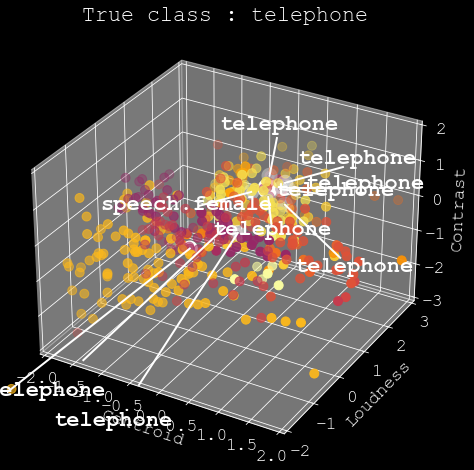

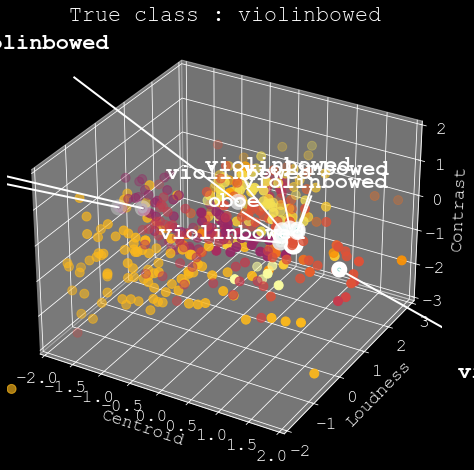

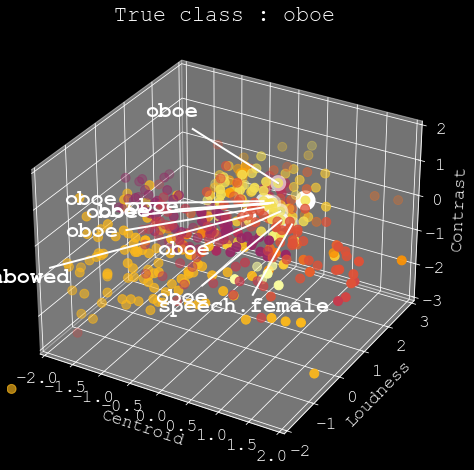

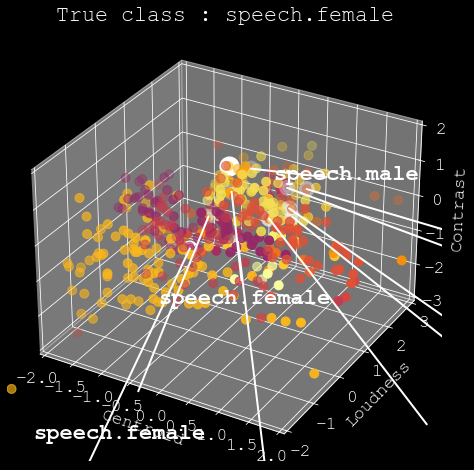

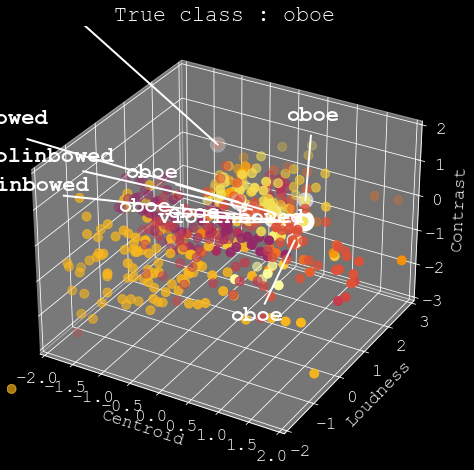

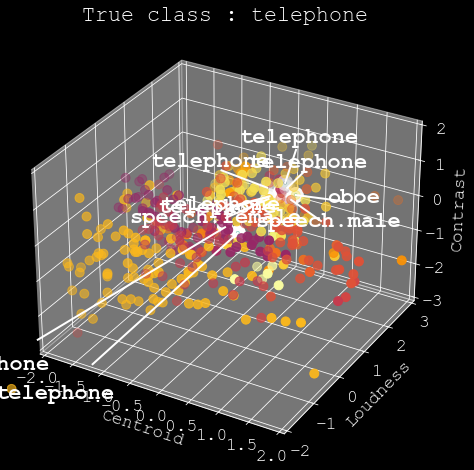

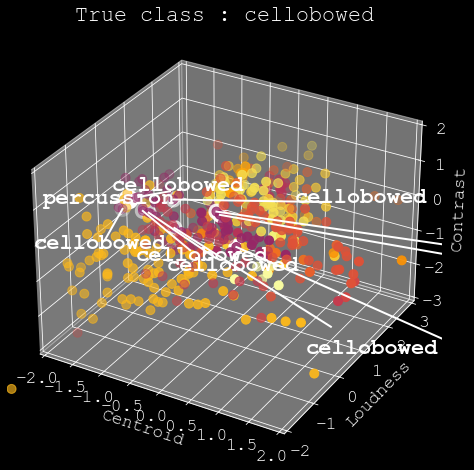

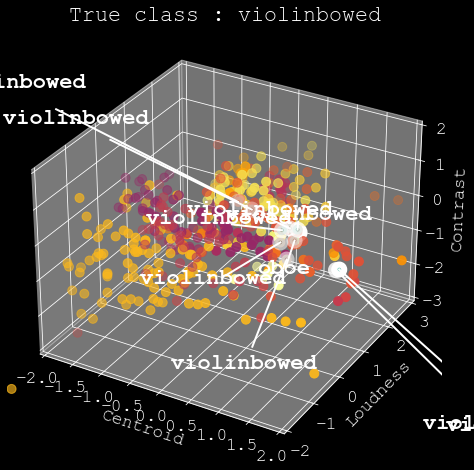

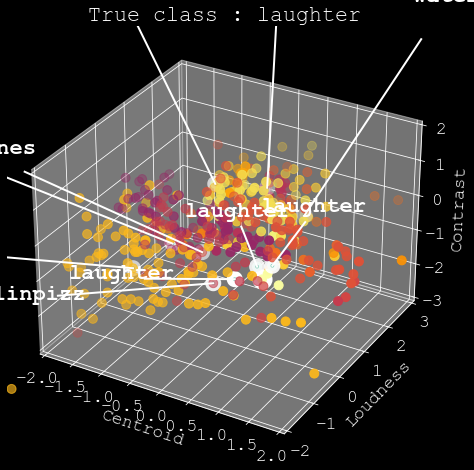

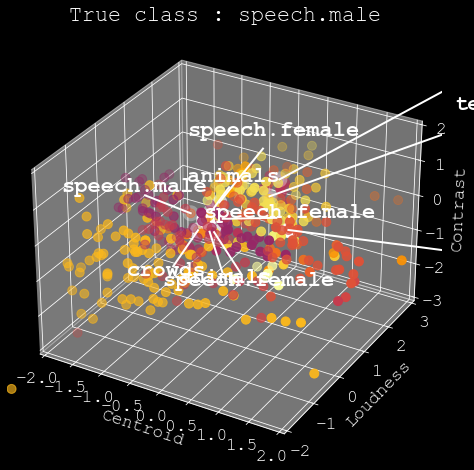

In [8]:
from helper_plot import hdr_plot_style
hdr_plot_style()
# Create a vector of colors
color_vect = plt.cm.inferno_r.colors[1::10]
# Q 1.1.1 - Perform some 10-NN queries and plot the result
for test in range(10):
    select_id = int(np.random.randint(low=0, high=len(data_struct["filenames"]), size=1))
    select_mask = [True] * len(data_struct["filenames"])
    select_mask[select_id] = False
    tmp_copy = data_matrix[select_mask]
    tmp_class = data_struct["classes"][select_mask]
    
    ######################
    # YOUR CODE GOES HERE
    ######################
    nn_ids = np.argsort(dist[select_id])[1:11]  #cuz the first one is just the selected sample itself
    
    # Performing a slightly complicated plot
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111, projection='3d')
    for c in range(len(data_struct["class_names"])):
        cur_points = (data_struct["classes"] == c)
        curColor = color_vect[c]
        s = ax.scatter(xs=data_matrix[cur_points, 0], ys=data_matrix[cur_points, 1], zs=data_matrix[cur_points, 2], s=80, c=np.array(curColor).reshape(1, -1));
    s = ax.scatter(tmp_copy[nn_ids[:10], 0], tmp_copy[nn_ids[:10], 1], tmp_copy[nn_ids[:10], 2], s=100, linewidths=6, edgecolor='w');
    s.set_edgecolors = s.set_facecolors = lambda *args:None
    s = ax.scatter(data_matrix[select_id, 0], data_matrix[select_id, 1], data_matrix[select_id, 2], s=200, linewidths=6, edgecolor='w');
    for t in range(10):
        fD = (tmp_copy[nn_ids[t], :] - data_matrix[select_id, :]) * 4;
        s = ax.text(tmp_copy[nn_ids[t], 0] + fD[0], tmp_copy[nn_ids[t], 1] + fD[1], tmp_copy[nn_ids[t], 2] + fD[2], data_struct["class_names"][tmp_class[nn_ids[t]]], fontsize=22, fontweight='bold', horizontalalignment='center');
        s.set_edgecolors = s.set_facecolors = lambda *args:None; s.set_zorder(200)
        lines = ax.plot([tmp_copy[nn_ids[t], 0], tmp_copy[nn_ids[t], 0] + (fD[0] * 0.8)], [tmp_copy[nn_ids[t], 1], tmp_copy[nn_ids[t], 1] + (fD[1] * 0.8)], [tmp_copy[nn_ids[t], 2], tmp_copy[nn_ids[t], 2] + (fD[2] * 0.8)], linewidth=2, c='w')
        for l in lines:
            l.set_zorder(199)
    ax.set_xlabel('Centroid'); ax.set_xlim(-2, 2); ax.set_ylabel('Loudness'); ax.set_ylim(-2, 3); ax.set_zlabel('Contrast'); ax.set_zlim(-3, 2); 
    ax.set_title('True class : ' + data_struct["class_names"][data_struct["classes"][select_id]]);
    ax.dist = 10
    plt.show()

#### Going further

Of course, based on the types of features, different distance measures can be used, such as any of the $l_{p}$ distances (a generalization of the Euclidean distance)

$$
l_{p}\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)=\sqrt[p]{\sum_{d=1}^{D}\left|f_{i,m}^{d}-f_{j,m}^{d}\right|^{p}}
$$

the *Cosine* distance

$$
cosine\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)=1-\frac{\mathbf{f_{i,m}}\cdot\mathbf{f_{j,m}}}{\left\Vert \mathbf{f_{i,m}}\right\Vert \left\Vert \mathbf{f_{j,m}}\right\Vert }=1-\frac{\sum_{d=1}^{D}f_{i,m}^{d}f_{j,m}^{d}}{\sum_{d=1}^{D}\left(f_{i,m}^{d}\right)^{2}\sum_{d=1}^{D}\left(f_{j,m}^{d}\right)^{2}}
$$

or the *correlation* distance.

$$
correlation\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)=1-\frac{\mathbf{\left(f_{i,m}-\mu_{\mathbf{f_{i,m}}}\right)}\cdot\left(\mathbf{f_{j,m}}-\mu_{\mathbf{f_{j,m}}}\right)}{\left\Vert \mathbf{f_{i,m}-\mu_{\mathbf{f_{i,m}}}}\right\Vert \left\Vert \mathbf{f_{j,m}}-\mu_{\mathbf{f_{j,m}}}\right\Vert }
$$

The same observation holds for the way we decided to "merge" the different distances. By looking at these given definitions, start by thinking about the following questions.

***

**Exercise**

  4. Implement the $l_{p}$, *Cosine* and *correlation* distances
  5. Try the same piece of code by varying the distances and the `used_features`.
  6. What can you tell about the discriminative power of features?
  7. What other steps should we perform on the features?
  8. (Optional) Extend your code to include temporal features
  9. (Optional) Extend your code to a fully functional *Query-By-Example* (QBE) system.

***

In [9]:
######################
# YOUR CODE GOES HERE
######################
def lp_distance(a, b, p=2):
    return (np.sum((a - b)**p))**(1/p)

def cosine_distance(a, b):
    distance = 1 - np.dot(a, b)/np.sqrt(np.dot(a, b)) * np.sqrt(np.dot(b, b,))
    return distance

def correlation_distance(a, b):
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    distance = 1 - np.dot(a - mean_a, b - mean_b) / (lp_distance(a, a - mean_a)*lp_distance(b, b - mean_b))
    return distance
    

<a id="classification"> </a>
## Classification

For the second part of this tutorial, we will rely on the same technique (computing the distance of a selected point to the rest of the dataset) in a *classification* framework. The overarching idea behind $k$-NN classification is that elements from a same class should have similar properties in the *feature space*. Hence, the closest feature to those of an element should be from elements of its right class. These types of approaches are usually termed as *distance-based* classification methods. The skeleton for this algorithm is provided in the `knn_classify` function.

```Python
def knn_classify(data_struct, test_sample, k, normalize, useL1dist):
    """
    % This function is used for classifying an unknown sample using the kNN
    % algorithm, in its multi-class form.
    %
    % Arguments :
    % - data_struct  : the data structure
    % - test_sample  : the input sample id to be classified
    % - k           : the k (number of neighbors) parameter
    % - dist_type    : type of distance ['Euclidean', 'Manhattan', 'Cosine'] (optional)
    % - normalize   : use class priors to weight results (optional)
    % Returns :
    % - probas      : an array that contains the classification probabilities for each class
    % - winner_class : the label of the winner class
    """
    return probas, winner_class
```

The algorithm will globally look quite similar to the previous one. However, this time we will compute the $k$ Nearest Neighbors *for each of the classes separately*, which will allow to consider the resulting distance vectors as probabilities. 

Hence, we will compute for the set of classes $\mathcal{C}_{t}$ the vector of distances, and select the $k$ closest elements per class.

$$
\begin{equation}
kNN_{\mathcal{C}_{t}}\left(e_{i}\right)=\overset{k}{\underset{j\in\mathcal{C}_{t} \wedge j\neq i}{argmin}}\left(\frac{1}{M}\sum_{m=1}^{M}\left(\mathcal{D}\left(\mathbf{f_{i,m}},\mathbf{f_{j,m}}\right)\right)\right)
\end{equation}
$$

Then, in order to consider the distances as probabilities, we compute for each class the mean distance of its $k$ nearest neighbors and normalize these distances across classes

$$
p_{\mathcal{C}_{t}}\left(e_{i}\right)=\frac{1}{k}\sum_{j=1}^{k}kNN_{\mathcal{C}_{t}}\left(e_{i}\right)
$$

In the `knn_classify` function, we store in `testFeatures` the vector of features from the element we are trying to classify, and construct a cell of features for each class in the `class_feats` cell.

***

**Exercise**  

  1. Update the `knn_classify` code to perform the basic k-NN classification function
  2. Run the algorithms for both 1-NN and 5-NN evaluation
  3. Plot the different confusion matrix to visually check the accuracies (you should obtain the values displayed in the following figure).
  4. Extend the code to take various distances into account (argument `dist_type`)
  5. What is the use of "class weighting" (argument `normalize`)?
  6. Implement the class weighting system and evaluate its effect
  4. Perform the same classification with various K and features to evaluate the properties and qualities of different parametrizations.
  5. (Optional) Automatize the evaluation of various configurations.
 
***

([<matplotlib.axis.XTick at 0x7f5545982b50>,
 [Text(0, 0, 'laughter'),
  Text(1, 0, 'bells'),
  Text(2, 0, 'oboe'),
  Text(3, 0, 'speech.female'),
  Text(4, 0, 'percussion'),
  Text(5, 0, 'altotrombone'),
  Text(6, 0, 'water'),
  Text(7, 0, 'crowds'),
  Text(8, 0, 'animals'),
  Text(9, 0, 'speech.male'),
  Text(10, 0, 'violinbowed'),
  Text(11, 0, 'machines'),
  Text(12, 0, 'violinpizz'),
  Text(13, 0, 'telephone'),
  Text(14, 0, 'tubularbells'),
  Text(15, 0, 'cellobowed')])

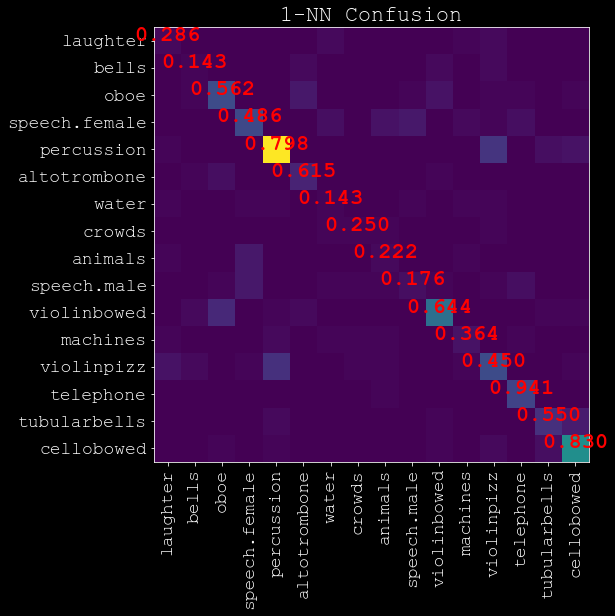

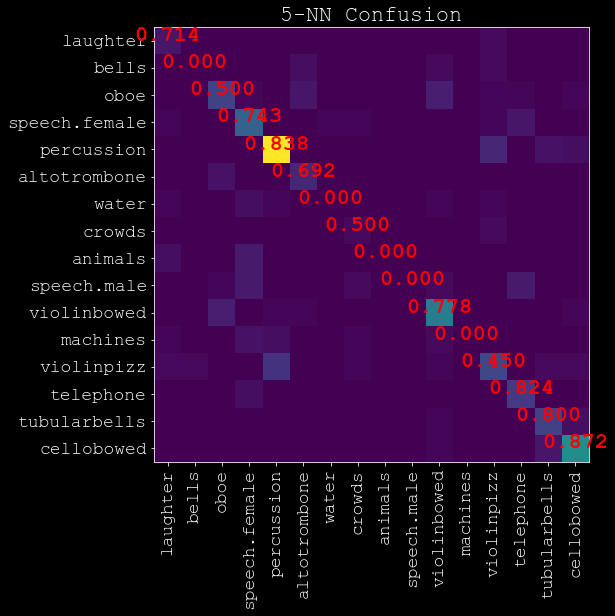

In [10]:
#%%
# 1.2 - K-Nearest Neighbors classification based on static properties
#
nb_classes = len(data_struct["class_names"])
nb_files = len(data_struct["filenames"])
correct_elements_1NN = 0
confusion_matrix_1NN = np.zeros((nb_classes, nb_classes))
probas_matrix_1NN = np.zeros((nb_files, nb_classes))
correct_elements_5NN = 0
confusion_matrix_5NN = np.zeros((nb_classes, nb_classes))
probas_matrix_5NN = np.zeros((nb_files, nb_classes))


# My code here!
def get_distance(a, b, dist_type="Euclidean"):
    if dist_type == "Euclidean":
        return (np.sum((a - b)**2))**(1/2)
    else:
        raise NotImplementedError()


#
# function [probas, winner_class] = knn_classify(data_struct, test_sample, k, normalize, useL1dist);
# 
def knn_classify(data_struct, test_sample, usedFeatures, k=1, dist_type='Euclidean', normalize=0):
    # Keep the number of classes
    n_classes = len(data_struct["class_names"]);
    # Initialization of class properties
    #n_dims = np.zeros(n_classes)
    #n_samples = np.zeros(n_classes)
    class_feats = []
    # Create a data matrix with the features of all data
    data_matrix = np.zeros((len(data_struct["filenames"]), len(usedFeatures)))
    for f in range(len(usedFeatures)):
        data_matrix[:, f] = np.array(data_struct[used_features[f]])
        # Remove NaN and Inf
        data_matrix[:, f] = np.nan_to_num(data_matrix[:, f])
        data_matrix[:, f] = data_matrix[:, f] / np.max(data_matrix[:, f])
    # Retrieve the features of the test samples
    testFeatures = data_matrix[test_sample, :]
    # dist{i} will the vector of distance of the testing sample to all the samples of i-th class
    dist = []
    # We create a vector of "inf" distances for each class and a cell of features
    for i in range(n_classes):
        # Retrieve the class points
        cur_points = np.linspace(0, len(data_struct["classes"])-1, len(data_struct["classes"]), dtype=int)[data_struct["classes"] == i]
        # Eventually remove the current sample
        cur_points = cur_points[cur_points != test_sample]
        #n_samples[i] = len(cur_points)
        #n_dims[i] = len(usedFeatures)
        
        # Fill the dist cell with "inf" values
        #dist.append(np.inf * np.ones(int(np.max(n_samples)))) #? Not sure why we need that
        dist.append(np.inf * np.ones(len(cur_points)))
        # Keep the cell of class features
        class_feats.append(data_matrix[cur_points, :])
        class_feats[i] = np.nan_to_num(class_feats[i])
    
    for i in range(n_classes):
        for j, feat in enumerate(class_feats[i]):
            distance = get_distance(testFeatures, feat, dist_type)
            test = np.linalg.norm(testFeatures - feat)
            dist[i][j] = distance
    
    kAll = np.zeros((n_classes, 1))
    # Compute the mean distance value for k neighbors
    for i in range(n_classes):
        kAll[i] += np.mean(sorted(dist[i])[:k])
    # Normalize the class probabilities
    probas = 1 - kAll / np.sum(kAll)
    # Retrieve the winning class
    winner_class = np.argmax(probas)
    return probas, winner_class

# Q 1.2.1 Perform 1-NN and 5-NN classification
# 1-NN Classification
for f in range(nb_files):
    # Perform 5-NN classification
    probas, winClass = knn_classify(data_struct, f, ['spectral_centroid_mean', 'loudness_mean', 'spectral_contrast_mean'], k=1)
    if (winClass == data_struct["classes"][f]):
        correct_elements_1NN = correct_elements_1NN + 1
    confusion_matrix_1NN[data_struct["classes"][f], winClass] = confusion_matrix_1NN[data_struct["classes"][f], winClass] + 1
    probas_matrix_1NN[f, :] = probas[0, :]
for f in range(nb_files):
    # Perform 5-NN classification
    probas, winClass = knn_classify(data_struct, f, ['spectral_centroid_mean', 'loudness_mean', 'spectral_contrast_mean'], k=5)
    if (winClass == data_struct["classes"][f]):
        correct_elements_5NN = correct_elements_5NN + 1
    confusion_matrix_5NN[data_struct["classes"][f], winClass] = confusion_matrix_5NN[data_struct["classes"][f], winClass] + 1
    probas_matrix_5NN[f, :] = probas[0, :]


# Q 1.2.3 - Plotting the confusion matrices
# 1-NN
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_1NN)
#plt.set_cmap(plt.jet)
plt.title('1-NN Confusion')
for c in range(confusion_matrix_1NN.shape[0]):
    plt.text(c, c, '%.3f'%(confusion_matrix_1NN[c, c] / np.sum(confusion_matrix_1NN[c, :])), fontsize=22, fontweight='bold', color=[1, 0, 0], horizontalalignment='center')
plt.yticks(range(len(data_struct["class_names"])), data_struct["class_names"])
plt.xticks(range(len(data_struct["class_names"])), data_struct["class_names"], rotation=90)

# 5-NN
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_5NN)
#plt.set_cmap(plt.jet)
plt.title('5-NN Confusion')
for c in range(confusion_matrix_5NN.shape[0]):
    plt.text(c, c, '%.3f'%(confusion_matrix_5NN[c, c] / np.sum(confusion_matrix_5NN[c, :])), fontsize=22, fontweight='bold', color=[1, 0, 0], horizontalalignment='center')
plt.yticks(range(len(data_struct["class_names"])), data_struct["class_names"])
plt.xticks(range(len(data_struct["class_names"])), data_struct["class_names"], rotation=90)

<a id="evaluation"> </a>
## Evaluation

When proposing machine learning algorithms, the fundamental aspects lies in correctly evaluating their performances. Depending on the application, methods, dataset and even the nature of corresponding data, a plethora of evaluation measures can be used. We highly recommend the following articles for those interested in machine learning, so that you develop your critical mind and do not limit yourself to narrow evaluations (by relying on statistical tests) and also that you avoid **cherry picking**  

  * Demšar, J. (2006).   *Statistical comparisons of classifiers over multiple data sets.*   The Journal of Machine Learning Research, 7, 1-30.   [PDF](http://machinelearning.wustl.edu/mlpapers/paper_files/Demsar06.pdf)  
  * Sturm, B. L. (2013).   *Classification accuracy is not enough.*   Journal of Intelligent Information Systems, **41**(3), 371-406. [PDF](http://vbn.aau.dk/files/70797941/Sturm20121030.pdf)  
  * Keogh, E., & Kasetty, S. (2003).   *On the need for time series data mining benchmarks: a survey and empirical demonstration.*   Data Mining and knowledge discovery, **7**(4), 349-371. [PDF](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.2240&rep=rep1&type=pdf)  

However, for the scope of this tutorial, we will limit ourselves to typical measures minimally required to evaluate your classifier. Overall, the most important aspects of evaluation lies in different ways of comparing the *real labels* (ground truth) to the *assigned labels* (picked by the classifier).

  * The **confusion matrix** is computed simply by counting the occurences in which a particular instance of a real label (row) is classified to an assigned label (column). This code is already provided in the starter code, and all the following measures can be derived directly from it.
  * The **overall accuracy** is computed as the ratio of correctly classified examples divided by the complete number of examples.
  * The (per-class) **precision** defines the ratio of examples correctly assigned to a class divided by the number of instances assigned to that class by the classifier.
  * The (per-class) **recall** defines the ratio of examples correctly assigned to a class divided by the number of instances really belonging to that class.
  * The **F1 measure** is defined as the ratio between the geometric and harmonic means between the precision and recall measures.

You can implement these measures by simply completing the starter code. If you have doubts about the implementation of these measures, you can check the corresponding [Wikipedia article](https://en.wikipedia.org/wiki/Precision_and_recall)

***

**Exercise**  

  1. Implement the *accuracy*, *recall*, *precision* and *F1 measure*
  2. Evaluate the previous algorithms with your new measures.
  3. Perform an automatization of the previous evaluations.
  4. Run the automatic evaluation for different K, distances and features.
  5. Plot the corresponding results for comparison
    
***

In [11]:
#%%
# 1.3 - Evaluating classification accuracy with various measures
#
# Type of normalization
normalizationMode = 2
# number of classes
nClasses = confusion_matrix_1NN.shape[0]
# confusion matrix normalization:

######################
# YOUR CODE GOES HERE
######################
if (normalizationMode == 1): 
    print('Standard normalization')
    confusion_matrix_1NN /= np.sum(confusion_matrix_1NN)
elif (normalizationMode == 2): 
    print('Row-wise normalization')
    confusion_matrix_1NN /= np.sum(confusion_matrix_1NN, 1)
else:         
    print('No normalization')

Row-wise normalization


In [12]:
# compute overal accuracy
def compute_accuracy(confusion_matrix):
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)  # Overall accuracy
    return accuracy

# compute class precision
def compute_precisions(confusion_matrix):
    precisions = np.diagonal(confusion_matrix) / np.sum(confusion_matrix, 1)
    return precisions

# compute class recall
def compute_recalls(confusion_matrix):
    recalls = np.diagonal(confusion_matrix) / np.sum(confusion_matrix, 0)
    return recalls
# compute class F1 measure
def compute_f1_measures(precisions, recalls):
    f1_measures = 2 * precisions * recalls / (precisions + recalls)
    return f1_measures

    
def normalize_confusion_matrix(confusionMatrix, normalizationMode=2):
    if (normalizationMode == 1): 
        print('Standard normalization')
        confusionMatrix /= np.sum(confusionMatrix)
    elif (normalizationMode == 2): 
        print('Row-wise normalization')
        confusionMatrix /= np.sum(confusionMatrix, 1)
    else:         
        print('No normalization')
    return confusionMatrix

    
maxK = 10
classPrecisions = np.zeros((maxK, nClasses))
classRecalls = np.zeros((maxK, nClasses))
classF1Measures = np.zeros((maxK, nClasses))
# Q 1.3.4 - Evaluate per-class precisions and recalls for various K
for k in range(maxK):
    correct_elements = 0
    confusionMatrix = np.zeros((nb_classes, nb_classes))
    for f in range(nb_files):
        # Perform k-NN classification
        _, winClass = knn_classify(data_struct, f, ['spectral_centroid_mean', 'loudness_mean', 'spectral_contrast_mean'], k=k)
        if (winClass == data_struct["classes"][f]):
            correct_elements = correct_elements + 1
        confusionMatrix[data_struct["classes"][f], winClass] = confusionMatrix[data_struct["classes"][f], winClass] + 1
    confusionMatrix = normalize_confusion_matrix(confusionMatrix)
    confusionMatrix += 1e-16  # to avoid NaNs
    classPrecisions[k] = compute_precisions(confusionMatrix)
    classRecalls[k] = compute_recalls(confusionMatrix)
    classF1Measures[k] = compute_f1_measures(classPrecisions[k], classRecalls[k])

Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization
Row-wise normalization


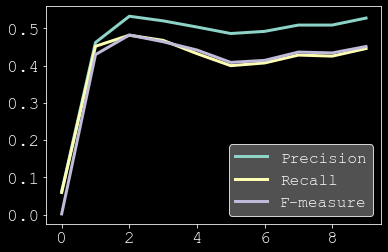

In [14]:
#%% Plot the evaluations for different K
######################
# YOUR CODE GOES HERE
######################
fig, ax = plt.subplots()
ax.plot(classPrecisions.mean(1), label="Precision")
ax.plot(classRecalls.mean(1), label="Recall")
ax.plot(classF1Measures.mean(1), label="F-measure")
ax.legend()

# => Meileurs résultats pour K=2